# Sub Question Query Engine as a workflow

LlamaIndex has a built-in Sub-Question Query Engine. Here, we replace it with a Workflow-based equivalent.

First we install our dependencies:
* LlamaIndex core for most things
* OpenAI LLM and embeddings for LLM actions
* `llama-index-readers-file` to power the PDF reader in `SimpleDirectoryReader`

In [ ]:
!pip install llama-index-core llama-index-llms-openai llama-index-embeddings-openai llama-index-readers-file llama-index-utils-workflow

Bring in our dependencies as imports:

In [ ]:
import os, json
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage,
)
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent,
)
from llama_index.core.agent import ReActAgent
from llama_index.llms.openai import OpenAI
from llama_index.utils.workflow import draw_all_possible_flows

# Define the Sub Question Query Engine as a Workflow

* Our StartEvent goes to `query()`, which takes care of several things:
  * Accepts and stores the original query
  * Stores the LLM to handle the queries
  * Stores the list of tools to enable sub-questions
  * Passes the original question to the LLM, asking it to split up the question into sub-questions
  * Fires off a `QueryEvent` for every sub-question generated

* QueryEvents go to `sub_question()`, which instantiates a new ReAct agent with the full list of tools available and lets it select which one to use.
  * This is slightly better than the actual SQQE built-in to LlamaIndex, which cannot use multiple tools
  * Each QueryEvent generates an `AnswerEvent`

* AnswerEvents go to `combine_answers()`.
  * This uses `self.collect_events()` to wait for every QueryEvent to return an answer.
  * All the answers are then combined into a final prompt for the LLM to consolidate them into a single response
  * A StopEvent is generated to return the final result

In [ ]:
class QueryEvent(Event):
    question: str


class AnswerEvent(Event):
    question: str
    answer: str


class SubQuestionQueryEngine(Workflow):
    @step
    async def query(self, ctx: Context, ev: StartEvent) -> QueryEvent:
        if hasattr(ev, "query"):
            await ctx.set("original_query", ev.query)
            print(f"Query is {await ctx.get('original_query')}")

        if hasattr(ev, "llm"):
            await ctx.set("llm", ev.llm)

        if hasattr(ev, "tools"):
            await ctx.set("tools", ev.tools)

        response = (await ctx.get("llm")).complete(
            f"""
            Given a user question, and a list of tools, output a list of
            relevant sub-questions, such that the answers to all the
            sub-questions put together will answer the question. Respond
            in pure JSON without any markdown, like this:
            {{
                "sub_questions": [
                    "What is the population of San Francisco?",
                    "What is the budget of San Francisco?",
                    "What is the GDP of San Francisco?"
                ]
            }}
            Here is the user question: {await ctx.get('original_query')}

            And here is the list of tools: {await ctx.get('tools')}
            """
        )

        print(f"Sub-questions are {response}")

        response_obj = json.loads(str(response))
        sub_questions = response_obj["sub_questions"]

        await ctx.set("sub_question_count", len(sub_questions))

        for question in sub_questions:
            self.send_event(QueryEvent(question=question))

        return None

    @step
    async def sub_question(self, ctx: Context, ev: QueryEvent) -> AnswerEvent:
        print(f"Sub-question is {ev.question}")

        agent = ReActAgent.from_tools(
            await ctx.get("tools"), llm=await ctx.get("llm"), verbose=True
        )
        response = agent.chat(ev.question)

        return AnswerEvent(question=ev.question, answer=str(response))

    @step
    async def combine_answers(
        self, ctx: Context, ev: AnswerEvent
    ) -> StopEvent | None:
        ready = ctx.collect_events(
            ev, [AnswerEvent] * await ctx.get("sub_question_count")
        )
        if ready is None:
            return None

        answers = "\n\n".join(
            [
                f"Question: {event.question}: \n Answer: {event.answer}"
                for event in ready
            ]
        )

        prompt = f"""
            You are given an overall question that has been split into sub-questions,
            each of which has been answered. Combine the answers to all the sub-questions
            into a single answer to the original question.

            Original question: {await ctx.get('original_query')}

            Sub-questions and answers:
            {answers}
        """

        print(f"Final prompt is {prompt}")

        response = (await ctx.get("llm")).complete(prompt)

        print("Final response is", response)

        return StopEvent(result=str(response))

In [ ]:
draw_all_possible_flows(
    SubQuestionQueryEngine, filename="sub_question_query_engine.html"
)

sub_question_query_engine.html


Visualizing this flow looks pretty linear, since it doesn't capture that `query()` can generate multiple parallel `QueryEvents` which get collected into `combine_answers`.

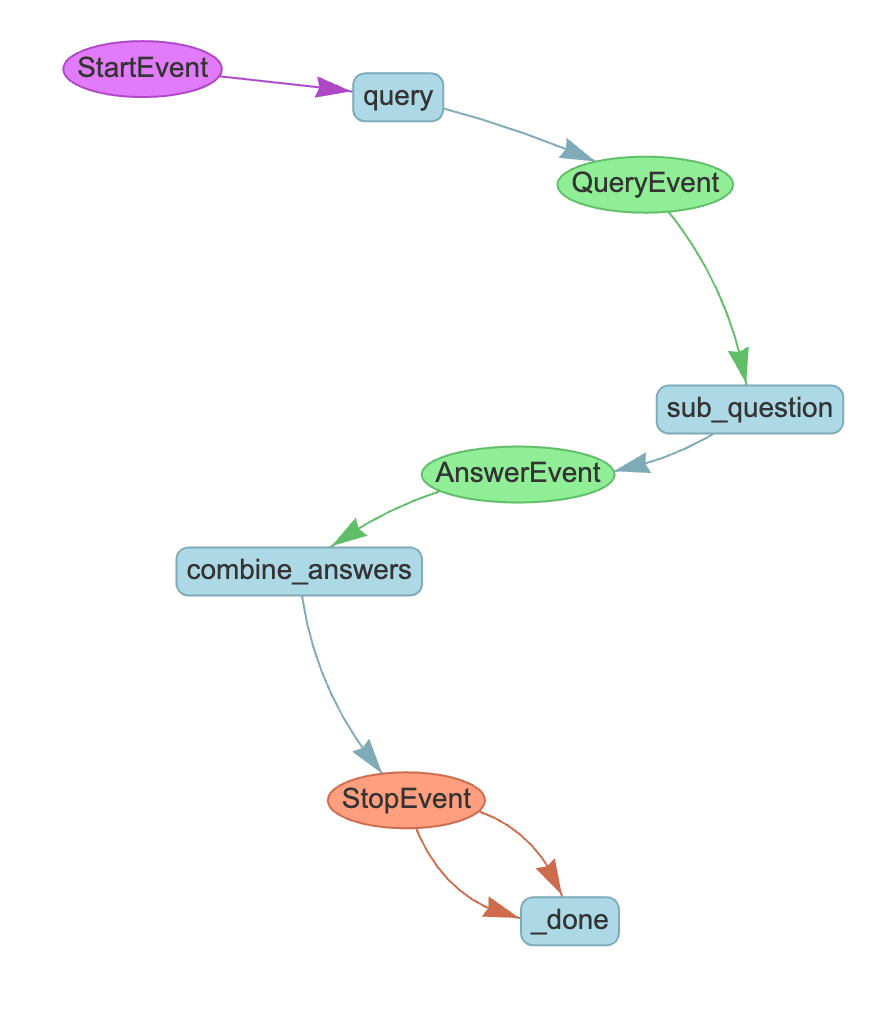

# Download data to demo

In [ ]:
!mkdir -p "./data/sf_budgets/"
!wget "https://www.dropbox.com/scl/fi/xt3squt47djba0j7emmjb/2016-CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf?rlkey=xs064cjs8cb4wma6t5pw2u2bl&dl=0" -O "./data/sf_budgets/2016 - CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf"
!wget "https://www.dropbox.com/scl/fi/jvw59g5nscu1m7f96tjre/2017-Proposed-Budget-FY2017-18-FY2018-19_1.pdf?rlkey=v988oigs2whtcy87ti9wti6od&dl=0" -O "./data/sf_budgets/2017 - 2017-Proposed-Budget-FY2017-18-FY2018-19_1.pdf"
!wget "https://www.dropbox.com/scl/fi/izknlwmbs7ia0lbn7zzyx/2018-o0181-18.pdf?rlkey=p5nv2ehtp7272ege3m9diqhei&dl=0" -O "./data/sf_budgets/2018 - 2018-o0181-18.pdf"
!wget "https://www.dropbox.com/scl/fi/1rstqm9rh5u5fr0tcjnxj/2019-Proposed-Budget-FY2019-20-FY2020-21.pdf?rlkey=3s2ivfx7z9bev1r840dlpbcgg&dl=0" -O "./data/sf_budgets/2019 - 2019-Proposed-Budget-FY2019-20-FY2020-21.pdf"
!wget "https://www.dropbox.com/scl/fi/7teuwxrjdyvgw0n8jjvk0/2021-AAO-FY20-21-FY21-22-09-11-2020-FINAL.pdf?rlkey=6br3wzxwj5fv1f1l8e69nbmhk&dl=0" -O "./data/sf_budgets/2021 - 2021-AAO-FY20-21-FY21-22-09-11-2020-FINAL.pdf"
!wget "https://www.dropbox.com/scl/fi/zhgqch4n6xbv9skgcknij/2022-AAO-FY2021-22-FY2022-23-FINAL-20210730.pdf?rlkey=h78t65dfaz3mqbpbhl1u9e309&dl=0" -O "./data/sf_budgets/2022 - 2022-AAO-FY2021-22-FY2022-23-FINAL-20210730.pdf"
!wget "https://www.dropbox.com/scl/fi/vip161t63s56vd94neqlt/2023-CSF_Proposed_Budget_Book_June_2023_Master_Web.pdf?rlkey=hemoce3w1jsuf6s2bz87g549i&dl=0" -O "./data/sf_budgets/2023 - 2023-CSF_Proposed_Budget_Book_June_2023_Master_Web.pdf"

--2024-08-07 18:21:11--  https://www.dropbox.com/scl/fi/xt3squt47djba0j7emmjb/2016-CSF_Budget_Book_2016_FINAL_WEB_with-cover-page.pdf?rlkey=xs064cjs8cb4wma6t5pw2u2bl&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucca241228aca55dbf9fcd60ae81.dl.dropboxusercontent.com/cd/0/inline/CYOq1NGkhLkELMmygLIg_gyLPXsOO7xOLjc3jW-mb09kevMykGPogSQx_icUTBEfHshxiSainXTynZYnh5O6uZ4ITeGiMkpvjl1QqXkKI34Ea8WzLr4FEyzkwohAC2WCQAU/file# [following]
--2024-08-07 18:21:12--  https://ucca241228aca55dbf9fcd60ae81.dl.dropboxusercontent.com/cd/0/inline/CYOq1NGkhLkELMmygLIg_gyLPXsOO7xOLjc3jW-mb09kevMykGPogSQx_icUTBEfHshxiSainXTynZYnh5O6uZ4ITeGiMkpvjl1QqXkKI34Ea8WzLr4FEyzkwohAC2WCQAU/file
Resolving ucca241228aca55dbf9fcd60ae81.dl.dropboxusercontent.com (ucca241228aca55dbf9fcd60ae81.dl.dropboxusercontent.com)... 162.125.1.15, 

# Load data and run the workflow

Just like using the built-in Sub-Question Query Engine, we create our query tools and instantiate an LLM and pass them in.

Each tool is its own query engine based on a single (very lengthy) San Francisco budget document, each of which is 300+ pages. To save time on repeated runs, we persist our generated indexes to disk.

In [ ]:
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("openai-key")

folder = "./data/sf_budgets/"
files = os.listdir(folder)

query_engine_tools = []
for file in files:
    year = file.split(" - ")[0]
    index_persist_path = f"./storage/budget-{year}/"

    if os.path.exists(index_persist_path):
        storage_context = StorageContext.from_defaults(
            persist_dir=index_persist_path
        )
        index = load_index_from_storage(storage_context)
    else:
        documents = SimpleDirectoryReader(
            input_files=[folder + file]
        ).load_data()
        index = VectorStoreIndex.from_documents(documents)
        index.storage_context.persist(index_persist_path)

    engine = index.as_query_engine()
    query_engine_tools.append(
        QueryEngineTool(
            query_engine=engine,
            metadata=ToolMetadata(
                name=f"budget_{year}",
                description=f"Information about San Francisco's budget in {year}",
            ),
        )
    )

engine = SubQuestionQueryEngine(timeout=120, verbose=True)
llm = OpenAI(model="gpt-4o")
result = await engine.run(
    llm=llm,
    tools=query_engine_tools,
    query="How has the total amount of San Francisco's budget changed from 2016 to 2023?",
)

print(result)

Running step query
Query is How has the total amount of San Francisco's budget changed from 2016 to 2023?
Sub-questions are {
    "sub_questions": [
        "What was the total amount of San Francisco's budget in 2016?",
        "What was the total amount of San Francisco's budget in 2017?",
        "What was the total amount of San Francisco's budget in 2018?",
        "What was the total amount of San Francisco's budget in 2019?",
        "What was the total amount of San Francisco's budget in 2020?",
        "What was the total amount of San Francisco's budget in 2021?",
        "What was the total amount of San Francisco's budget in 2022?",
        "What was the total amount of San Francisco's budget in 2023?"
    ]
}
Step query produced no event
Running step sub_question
Sub-question is What was the total amount of San Francisco's budget in 2016?
> Running step 61365946-614c-4895-8fc3-0968f2d63387. Step input: What was the total amount of San Francisco's budget in 2016?
Thought: T

Our debug output is lengthy! You can see the sub-questions being generated and then `sub_question()` being repeatedly invoked, each time generating a brief log of ReAct agent thoughts and actions to answer each smaller question.

You can see `combine_answers` running multiple times; these were triggered by each `AnswerEvent` but before all 8 `AnswerEvents` were collected. On its final run it generates a full prompt, combines the answers and returns the result.